<a href="https://colab.research.google.com/github/nerobite/neural_networks/blob/main/Detection_and_segmentation_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q kaggle

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
!kaggle competitions download -c the-nature-conservancy-fisheries-monitoring

100% 2.11G/2.11G [00:24<00:00, 64.3MB/s]
100% 2.11G/2.11G [00:24<00:00, 91.7MB/s]


In [15]:
!unzip the-nature-conservancy-fisheries-monitoring.zip

Archive:  the-nature-conservancy-fisheries-monitoring.zip
  inflating: sample_submission_stg1.csv.zip  
  inflating: sample_submission_stg2.csv.zip  
  inflating: test_stg1.zip           
  inflating: test_stg2.7z            
  inflating: train.zip               


In [16]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 22.2 MB/s eta 0:00:00


In [17]:
!unzip train.zip
!unzip test_stg1.zip

Archive:  train.zip
   creating: train/
  inflating: train/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/train/
  inflating: __MACOSX/train/._.DS_Store  
   creating: train/ALB/
  inflating: train/ALB/img_00003.jpg  
  inflating: train/ALB/img_00010.jpg  
  inflating: train/ALB/img_00012.jpg  
  inflating: train/ALB/img_00015.jpg  
  inflating: train/ALB/img_00019.jpg  
  inflating: train/ALB/img_00020.jpg  
  inflating: train/ALB/img_00029.jpg  
  inflating: train/ALB/img_00032.jpg  
  inflating: train/ALB/img_00037.jpg  
  inflating: train/ALB/img_00038.jpg  
  inflating: train/ALB/img_00039.jpg  
  inflating: train/ALB/img_00041.jpg  
  inflating: train/ALB/img_00043.jpg  
  inflating: train/ALB/img_00045.jpg  
  inflating: train/ALB/img_00055.jpg  
  inflating: train/ALB/img_00057.jpg  
  inflating: train/ALB/img_00074.jpg  
  inflating: train/ALB/img_00085.jpg  
  inflating: train/ALB/img_00090.jpg  
  inflating: train/ALB/img_00097.jpg  
  inflating: train/ALB/i

In [18]:
import py7zr
with py7zr.SevenZipFile("/content/test_stg2.7z", mode='r') as z:
    z.extractall()

In [19]:
import os
import cv2
import glob
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

print(tf.__version__)
print(tf.executing_eagerly())

2.15.0
True


In [9]:
!git clone https://github.com/a4tunado/lectures.git

Cloning into 'lectures'...
remote: Enumerating objects: 1158, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1158 (delta 9), reused 28 (delta 8), pack-reused 1127
Receiving objects: 100% (1158/1158), 239.63 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (287/287), done.
Updating files: 100% (561/561), done.


In [10]:
TRAIN_PREFIX = '/content/train'


def load_annotations():
    boxes = dict()
    for path in tqdm(glob.glob('lectures/007/data/fish/boxes/*.json')):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                    rect['class'] = label
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=10)
            img = cv2.putText(img.copy(), annotation['annotations'][i]['class'], tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img

    def __draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for i, rect in enumerate(rectangles):
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=3)
            img = cv2.putText(img.copy(), counts['class'][int(rect['label'])] + ': ' + str(rect['label']), tuple(np.array(pt1)+[0,-7]), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 4 )
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = __draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

In [11]:
#Визуализируем разметку
boxes = load_annotations()  # загружаем разметку детекций

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,bet,200
1,yft,734
2,dol,117
3,lag,67
4,alb,1719
5,shark,176


In [13]:
# зафиксируем перечень классов, чтобы при загрузке разметки (json) нумерация классов была всегда одинакова (не сбивалась)
counts = pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count']).sort_values(by='count', ascending=False).reset_index()
counts.drop(columns='index', inplace=True)
counts

,class,count
0,alb,1719
1,yft,734
2,bet,200
3,shark,176
4,dol,117
5,lag,67


In [14]:
fish_classes = counts['class'].values
fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

In [ ]:
# Легенда классификации рыб будет выглядеть так:
# class 0: alb - Albacore tuna
# class 1: yft - Yellowfin tuna
# class 2: bet - Bigeye tuna
# class 3: shark - Sharks
# class 4: dol - Dolphinfish (Mahi Mahi)
# class 5: lag - Opah, Moonfish (Lamprus Guttatus)

# Остальные классы - без разметки:
# nof - No Fishes (на фото нет никаких рыб)
# oth - Other Fishes (на фото другие рыбы, не относящиеся ни к одному из вышеперечисленных классов)

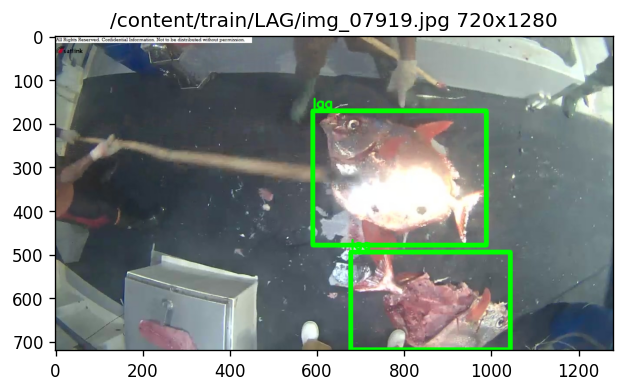

In [ ]:
annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

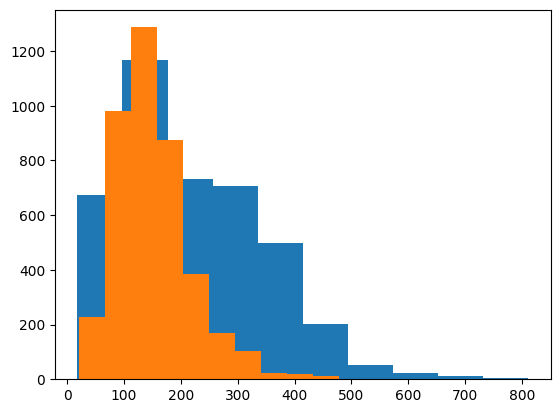

In [ ]:
#Распределение размеров разметки
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

In [15]:
# Экстрактор признаков
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

# Создаем новую модель, используя выходные данные features как входные
#feature_tensor = Model(inputs=features.input, outputs=features.output).output
feature_tensor = features.layers[-1].output
# Теперь feature_tensor будет содержать ожидаемые четырехмерные тензоры
print(feature_tensor.shape)

83683744/83683744 [==============================] - 5s 0us/step
(None, 24, 38, 2048)


In [16]:
#Сетка якорей (anchor grid)
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
num_classes = counts.shape[0]
num_classes

6

In [17]:
from scipy.special import softmax

In [18]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 11), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        label = fish_classes == rect['class']

        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = np.array([*label, 1., dx, dy, dw, dh])

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

#keras.activations.softmax(x, axis=-1)

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):

            label = np.empty(6)

            label[0], label[1], label[2], label[3], label[4], label[5], conf, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(conf)
            label = softmax(label)

            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf,
                                   'label': np.argmax(_sigmoid(label)),
                                   'labels': label })
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

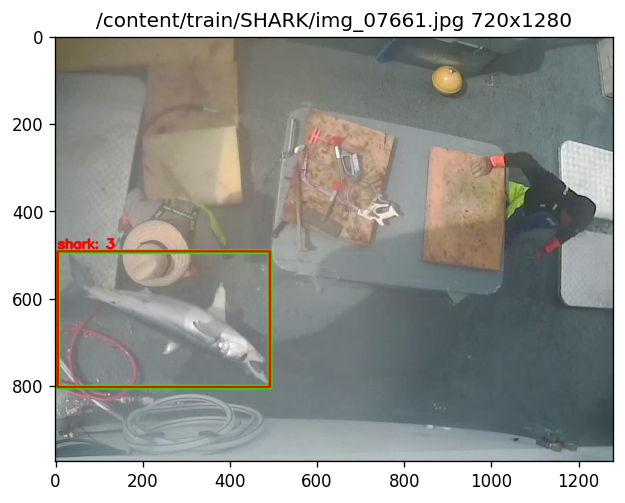

In [ ]:
annotation = boxes['shark'][3]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

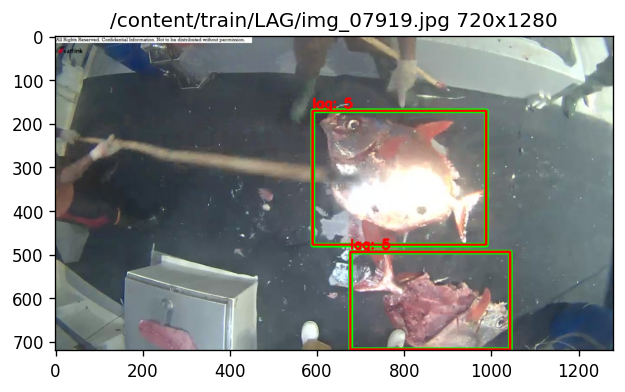

In [ ]:
#Валидация энкодинга/декодинга якорей
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.1)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

In [19]:
#Функция потерь
K = tf.keras.backend


def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 6],
                                      y_pred[..., 6],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., -4:] - y_pred[..., -4:])
    square_loss = 0.5 * K.square(y_true[..., -4:] - y_pred[..., -4:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def classification_loss(y_tr, y_pr, alpha=0.25, gamma=2.0):

    """Focal Loss"""
    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=y_true, logits=y_pred
    )
    probs = tf.nn.softmax(y_pred)
    alpha = tf.where(tf.equal(y_true, 1.0), alpha, (1.0 - alpha))
    pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
    loss = alpha * tf.pow(1.0 - pt, gamma) * cross_entropy

    return tf.reduce_sum(loss, axis=-1)

def class_loss(y_tr, y_pr):

    y_true = y_tr[..., :6]
    y_pred = y_pr[..., :6]

    cross_entropy = K.categorical_crossentropy(y_true[..., :6],
                                               y_pred[..., :6],
                                               from_logits=True)
#     tf.nn.sigmoid_cross_entropy_with_logits(
#         labels=y_true, logits=y_pred
#         )
    return cross_entropy

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 11))
    y_pred = K.reshape(y_pred, (batch_size, -1, 11))

    # TODO: добавьте функцию потерь для классификации детекции
    cls_loss = classification_loss(y_true, y_pred)
    #cls_loss = class_loss(y_true, y_pred)


    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 6], axis=-1)
    pos_class_loss = K.sum(cls_loss * y_true[..., 6], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 6], axis=-1)



    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 6], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 6]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    cls_loss = pos_class_loss / (num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss + cls_loss

In [20]:
#Загрузка данных
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, tf.keras.applications.resnet_v2.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                #print('boxes[j]', boxes[j])
                y_ = encode_anchors(boxes[j], img_shape)
                y.append(y_)
                X.append(img)
            yield np.array(X), np.array(y)

In [21]:
#Добавляем выход детектора
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output = tf.keras.layers.Conv2D(11,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2')(output)


model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 750, 1200, 3)]       0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 374, 599, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 374, 599, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 374, 599, 32)         0         ['block1_conv1_bn[0][0]'] 

In [ ]:
#Обучение
# adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
# model.compile(optimizer=adam,
#               loss=total_loss,
#               metrics=[confidence_loss])

In [22]:
lr=3e-3
def lr_exp_decay(epoch, lr):
    k = 0.5
    return lr * np.exp(-k*epoch)

batch_size = 5
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.hdf5',
    monitor='loss',
    verbose=47,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

adam = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,
              loss=total_loss,
              metrics=[confidence_loss, classification_loss, smooth_l1])

In [ ]:
model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=2,
          callbacks=[checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 1/2
  9/602 [..............................] - ETA: 3:45 - loss: 17.0937 - confidence_loss: 1.6740 - classification_loss: 1.6424 - smooth_l1: 5.7893
Epoch 1: loss improved from inf to 16.60446, saving model to fishdetector.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 19/602 [..............................] - ETA: 3:59 - loss: 13.7065 - confidence_loss: 1.3308 - classification_loss: 2.0276 - smooth_l1: 6.1309
Epoch 1: loss improved from 16.60446 to 13.33457, saving model to fishdetector.hdf5
 29/602 [>.............................] - ETA: 4:07 - loss: 11.6069 - confidence_loss: 1.0268 - classification_loss: 2.2244 - smooth_l1: 5.9592
Epoch 1: loss improved from 13.33457 to 11.38090, saving model to fishdetector.hdf5
 39/602 [>.............................] - ETA: 4:22 - loss: 10.0060 - confidence_loss: 0.8496 - classification_loss: 2.2926 - smooth_l1: 5.7796
Epoch 1: loss improved from 11.38090 to 9.84100, saving model to fishdetector.hdf5
 49/602 [=>............................] - ETA: 4:15 - loss: 8.7780 - confidence_loss: 0.7352 - classification_loss: 2.3412 - smooth_l1: 5.5139
Epoch 1: loss improved from 9.84100 to 8.66204, saving model to fishdetector.hdf5
 59/602 [=>............................] - ETA: 4:08 - loss: 7.8312 - confidence_loss: 0

In [23]:
model.load_weights('/content/fishdetector.hdf5')

1/1 [==============================] - 3s 3s/step


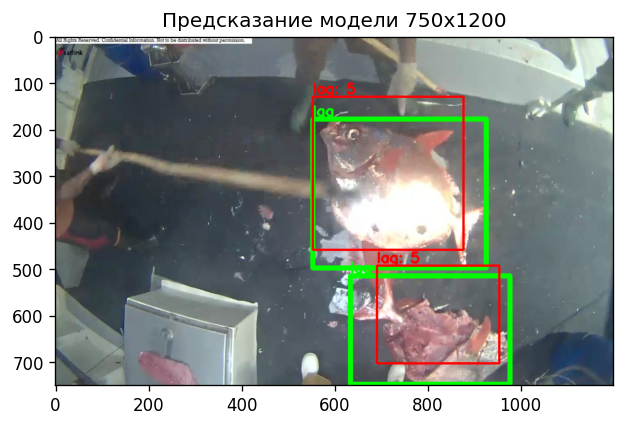

In [ ]:
#Результат работы детектора
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

1/1 [==============================] - 0s 37ms/step


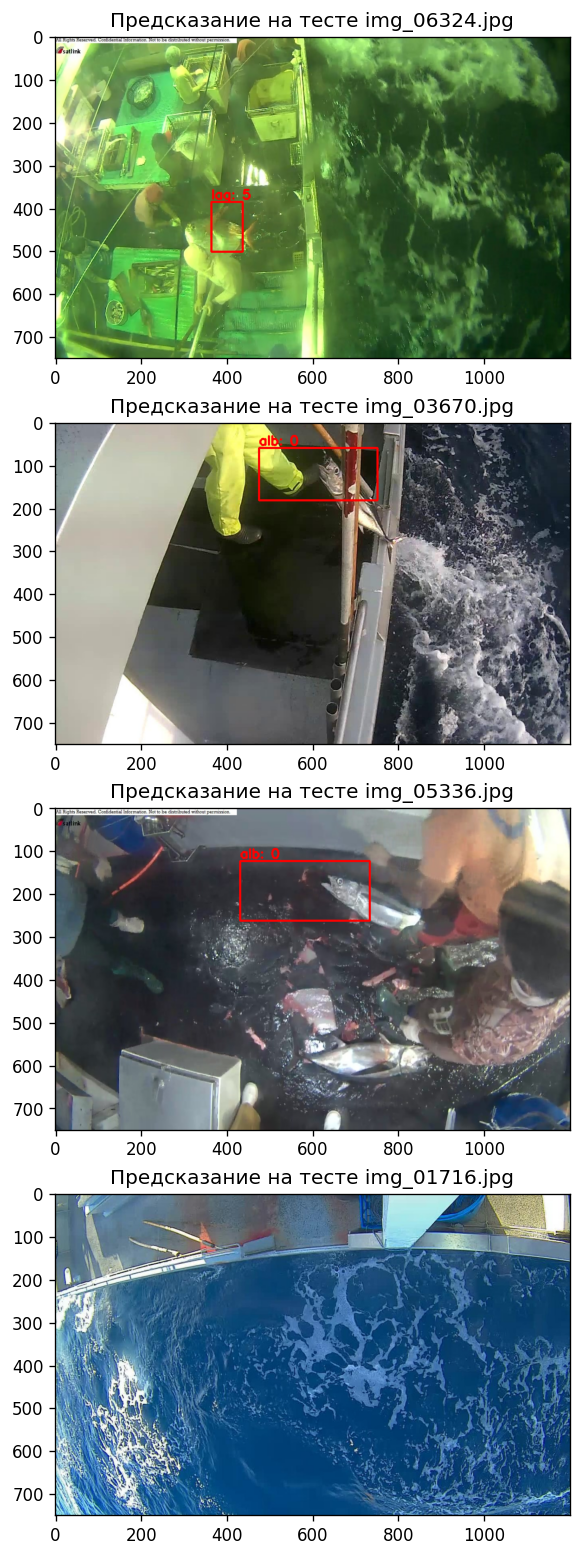

In [ ]:
#Визуализируем предсказание на тесте
test_images = glob.glob('/content/test_stg1/*.jpg')[:4]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)

    pred = model.predict(np.array([sample_img,]))
    decoded = decode_prediction(pred[0], conf_thr=0.1)
    decoded = non_max_suppression(decoded,
                                  max_output_size=1,
                                  iou_threshold=0.5)
    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename.split('/')[-1]));

In [ ]:
fish_classes

array(['alb', 'yft', 'bet', 'shark', 'dol', 'lag'], dtype=object)

In [24]:
def make_predictions():
    ptable = pd.DataFrame(columns=['image', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK','YFT'])

    for i, file in enumerate(tqdm(glob.glob('/content/test_stg1/*.jpg'))):
        bn = os.path.basename(file)
        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]
        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)
        decoded = decoded[0]['labels']

        ptable.loc[i, 'image'] = bn
        ptable.loc[i, 'ALB'] = decoded[5]
        ptable.loc[i, 'BET'] = decoded[1]
        ptable.loc[i, 'DOL'] = decoded[4]
        ptable.loc[i, 'LAG'] = decoded[3]
        ptable.loc[i, 'SHARK'] = decoded[0]
        ptable.loc[i, 'YFT'] = decoded[2]

        ptable.loc[i, 'NoF'] = 0.123081
        ptable.loc[i, 'OTHER'] = 0.079142

#         i += 1

    for j, file in enumerate(tqdm(glob.glob('/content/test_stg2/*.jpg'))):
        bn = os.path.basename(file)

        bn = "test_stg2/" + bn
        _, sample_img = load_img(file)

        pred = model.predict(np.array([sample_img,]))[0]

        decoded = decode_prediction(pred, conf_thr=0.015)
        decoded = non_max_suppression(decoded,
                              max_output_size=1,
                              iou_threshold=0.5)

        decoded = decoded[0]['labels']

        ptable.loc[i + j, 'image'] = bn
        ptable.loc[i + j, 'ALB'] = decoded[5]
        ptable.loc[i + j, 'BET'] = decoded[1]
        ptable.loc[i + j, 'DOL'] = decoded[4]
        ptable.loc[i + j, 'LAG'] = decoded[3]
        ptable.loc[i + j, 'SHARK'] = decoded[0]
        ptable.loc[i + j, 'YFT'] = decoded[2]

        ptable.loc[i + j, 'NoF'] = 0.123081
        ptable.loc[i + j, 'OTHER'] = 0.079142

    return ptable

In [25]:
pred_table = make_predictions()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 0/12153 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


In [40]:
pred_table #lost image img_02486.jpg

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_03739.jpg,0.016686,0.884735,0.026241,0.013708,0.123081,0.079142,0.005389,0.053241
1,img_04642.jpg,0.021159,0.00883,0.002998,0.00729,0.123081,0.079142,0.948395,0.011328
2,img_06203.jpg,0.06722,0.174199,0.181137,0.097512,0.123081,0.079142,0.150195,0.329736
3,img_06345.jpg,0.022459,0.9086,0.01644,0.011532,0.123081,0.079142,0.007295,0.033674
4,img_05824.jpg,0.076436,0.131263,0.060161,0.449107,0.123081,0.079142,0.206137,0.076896
...,...,...,...,...,...,...,...,...,...
13147,test_stg2/image_01286.jpg,0.056547,0.360312,0.099305,0.075614,0.123081,0.079142,0.29214,0.116081
13148,test_stg2/image_06663.jpg,0.060441,0.459457,0.091441,0.137361,0.123081,0.079142,0.102858,0.148443
13149,test_stg2/image_06931.jpg,0.088102,0.498992,0.058568,0.165768,0.123081,0.079142,0.064754,0.123817
13150,test_stg2/image_01834.jpg,0.011676,0.022474,0.012174,0.017528,0.123081,0.079142,0.923952,0.012196


In [42]:
pred_table.to_csv("submission_pred.csv", index=False)

In [ ]:
#Public Score = 2.7674